# HW3 ECE 495

## Tyler Klimas

### Problem 1  

#### import the mini MNIST dataset using sklearns datasets package, this dataset being 8 x 8 images with 900 samples

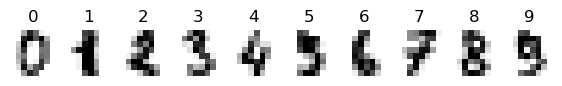

In [17]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from types import SimpleNamespace

digits = datasets.load_digits()
import matplotlib.pyplot as plt
%matplotlib inline

axes = plt.subplots(nrows=1, ncols=10, figsize=(7, 1))[1]
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(str(label))

#### In this problem we are only interested in 4 and 9, so using a mask which converts the labels to 0 and 1. This shrinks the dataset to 361 samples. After this we normalize the values by dividing by 16 to get the pixel values between 0 and 1. 

In [25]:
binary_conversion = (digits.target == 4) | (digits.target == 9)
x_binary = digits.data[binary_conversion]
y_binary = (digits.target[binary_conversion] == 9).astype(int)

x_binary /= 16.0

print(x_binary.shape),print(y_binary.shape)

(361, 64)
(361,)


(None, None)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

#### I split the dataset into 70% training and 30% testing data, and then cast the values from arrays into torch.tensors which allow me to use PyTorch linear models

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x_filtered, y_filtered, train_size=0.7, shuffle=True)
x_train, y_train = torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
x_test, y_test = torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

print(f"Training label distribution: {np.bincount(y_train.int().numpy())}")
print(f"Testing label distribution: {np.bincount(y_test.int().numpy())}")


Training label distribution: [126 126]
Testing label distribution: [55 54]


#### I created the Logistic regression model here, a very simple linear layer which takes 64 inputs (pixel values of the image vector) and outputs a weighted sum with the weights plus a bias

#### After this, I use binary cross entropy loss with logits loss, a PyTorch package which applies the sigmoid function that outputs a "Probability" between 0 and 1.

#### Then,

In [21]:
logistic_regression = nn.Linear(64, 1)
loss_function = nn.BCEWithLogitsLoss()
grad_update = optim.Adam(logistic_regression.parameters(), lr=0.01)

In [22]:
for epoch in range(200):
    grad_update.zero_grad()
    y_pred = logistic_regression(x_train).squeeze()
    loss = loss_function(y_pred, y_train)
    loss.backward()
    grad_update.step()
    if (epoch + 1) % 40 == 0:
        print(f'Epoch [{epoch+1}/200], Loss: {loss.item():.4f}')

Epoch [40/200], Loss: 0.1562
Epoch [80/200], Loss: 0.0819
Epoch [120/200], Loss: 0.0574
Epoch [160/200], Loss: 0.0443
Epoch [200/200], Loss: 0.0358


In [23]:
with torch.no_grad():
    y_pred = torch.sigmoid(logistic_regression(x_test)).squeeze().round()
    accuracy = (y_pred == y_test).float().mean().item()
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    y_pred_np = y_pred.numpy()
    y_test_np = y_test.numpy()
    print(confusion_matrix(y_test_np, y_pred_np))
    print(classification_report(y_test_np, y_pred_np))

Test Accuracy: 99.08%
[[54  1]
 [ 0 54]]
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        55
         1.0       0.98      1.00      0.99        54

    accuracy                           0.99       109
   macro avg       0.99      0.99      0.99       109
weighted avg       0.99      0.99      0.99       109



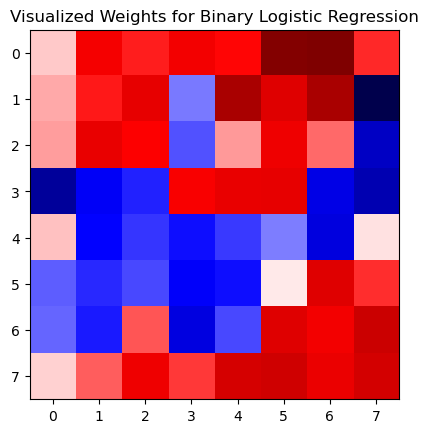

In [24]:
weights = logistic_regression.weight.detach().numpy().reshape(8, 8)

plt.imshow(weights, cmap='seismic')
plt.title('Visualized Weights for Binary Logistic Regression')
plt.show()